In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import torch
from torch.utils.data import SubsetRandomSampler

import numpy as np
%matplotlib inline

import bts.dataset as dataset
import bts.model as model
import bts.classifier as classifier
import bts.plot as plot

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Computation Details')
print(f'\tDevice Used: ({device})  {torch.cuda.get_device_name(torch.cuda.current_device())}\n')

print('Packages Used Versions:-')
print(f'\tPytorch Version: {torch.__version__}')

#tensorboard --logdir logs --samples_per_plugin images=200

Computation Details
	Device Used: (cuda)  GeForce GTX 1050 Ti

Packages Used Versions:-
	Pytorch Version: 1.0.1


In [2]:
# HYPERPARAMETERS
TEST_SPLIT = 0.2
BATCH_SIZE = 6
DATASET_PATH = os.path.join('dataset','png_dataset')
EPOCHS = 2
FILTER_LIST = [16,32,64,128,256]
TRAIN = False
LOAD_MODEL = True
SAVE_MODEL = not LOAD_MODEL
MODEL_NAME = f"UNet-{FILTER_LIST}.pt"

print(f"Model Name :   {MODEL_NAME}")

Model Name :   UNet-[16, 32, 64, 128, 256].pt


In [3]:
tumor_dataset = dataset.TumorDataset(DATASET_PATH)

indices = list(range(len(tumor_dataset)))
np.random.shuffle(indices)
split = int(np.floor(TEST_SPLIT * len(tumor_dataset)))

train_indices , test_indices = indices[split:], indices[:split]
train_sampler, test_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(test_indices)

trainloader = torch.utils.data.DataLoader(tumor_dataset, BATCH_SIZE, sampler=train_sampler)
testloader = torch.utils.data.DataLoader(tumor_dataset, 1, sampler=test_sampler)

In [4]:
unet_model = None
unet_classifier = None
if not LOAD_MODEL:
    unet_model = model.DynamicUNet(FILTER_LIST).to(device)
    unet_classifier = classifier.BrainTumorClassifier(unet_model,device)
else:
    unet_model = model.DynamicUNet(FILTER_LIST)
    unet_classifier = classifier.BrainTumorClassifier(unet_model,device)
    unet_classifier.restore_model(os.path.join('saved_models',MODEL_NAME))
    print('Saved model loaded')

In [5]:
"""
till = 8
choice = test_indices[:till]
sample = list()
for _ in range(till):
    sample.append(dataset[choice[_]])
"""

'\ntill = 8\nchoice = test_indices[:till]\nsample = list()\nfor _ in range(till):\n    sample.append(dataset[choice[_]])\n'

In [7]:
if TRAIN:
    unet_model.train()
    unet_train_history = unet_classifier.train(EPOCHS,trainloader,mini_batch=100)
    print(f'Training Finished after {EPOCHS} epoches')
    if SAVE_MODEL:
        path = os.path.join('saved_models',MODEL_NAME)
        unet_classifier.save_model(path)
        print(f'\tModel saved at location: {path}')
    unet_score = unet_classifier.test(testloader)
    print(f'\n\nDice Score {unet_score}')
else:
    unet_model.eval()
    unet_score = unet_classifier.test(testloader)
    print(f'Dice Score {unet_score}')

Starting Training Process
Training Finished after 150 epoches
	Model saved at location: saved_models\UNet-[16, 32, 64, 128, 256].pt


Dice Score 0.6397925335658668


# See Results

In [ ]:
save_plot = os.path.join('images',f'{MODEL_NAME}-loss_graph.png')
plot.loss_graph(unet_train_history['train_loss'],save_plot)

In [9]:
i=0

110  Image Name is 1320.png		 Dice Score: 0.8569


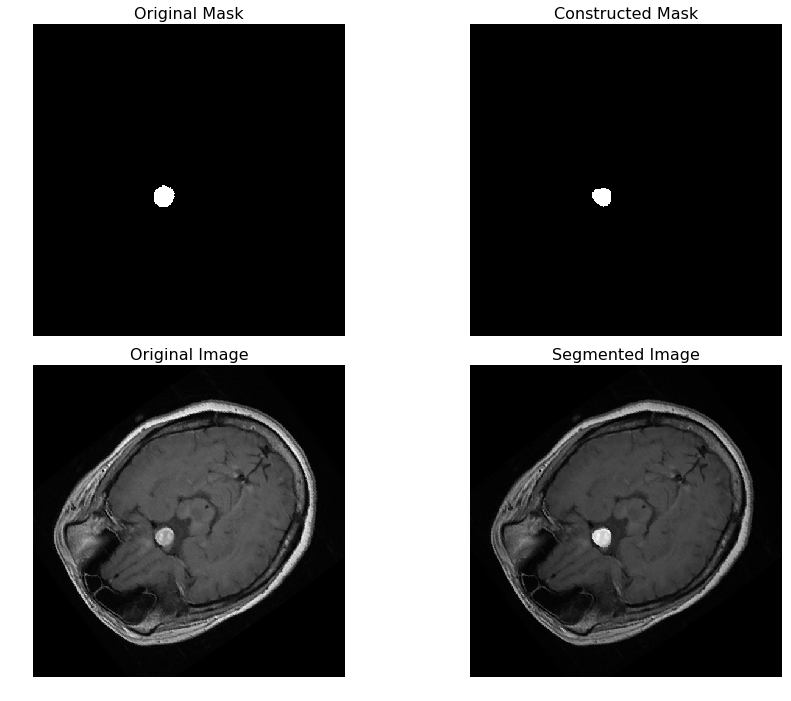

In [750]:
image_index = test_indices[i]
sample = tumor_dataset[image_index]
image, mask, output, d_score = unet_classifier.predict(sample,0.65)
print(f'{i}  Image Name is {image_index}.png\t\t Dice Score: {d_score:.4f}')
save_path = os.path.join('images',f'{d_score:.4f}_{image_index}.png')
plot.result(image,mask,output,0.4,save_path=save_path)
i += 1
if i >= len(test_indices):
    i = 0 